In [1]:
from google.colab import drive
import os
drive.mount('/content/drive/', force_remount=False)

#put the path to the directory with .csv files and 'images' folder on your google drive
datapath = '/content/drive/My Drive/ai-side-projects/road_segmentation/cityscapes_data/'

Mounted at /content/drive/


# Loading  [Cityscapes Image Pairs](https://www.kaggle.com/datasets/dansbecker/cityscapes-image-pairs/data#) kaggle dataset, [source](https://www.cityscapes-dataset.com)

Parts of code are from my projects or [this notebook](https://www.kaggle.com/code/tr1gg3rtrash/car-driving-segmentation-unet-from-scratch/notebook), or standatd tutorials.

My goal is to make a road detection network.

In [3]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image
import os
from tqdm import tqdm
import cv2


# Data preparation and road mask selection

## Road mask with color filtering


Original segmentation map is not very useful since it has different possible colors for a given class (e.g. `road` is marked with magenta, but  do **not** have a constant color code).

Initial approach is to select a possible range of colors of `road` class colors and make a mask from it, but it is very noisy (see the first mask below).

I opted to smooth the mask image first and then make a magenta color mask and the image is smoother.  The resulted mask is much more continuous, but edge effects can be seen. So far I ignore it.

In [4]:
def filter_road_colors(img):
  # Define the range of RGB values for roads
  road_color_lower = np.array([110, 50, 120])
  road_color_upper = np.array([130, 70, 130])

  # Create road mask
  road_mask = np.all((img >= road_color_lower) & (img <= road_color_upper), axis=-1)

  # Convert boolean mask to an image with zeros and ones
  road_mask = road_mask.astype(np.uint8)

  return road_mask


def preprocess(path, smoothing_scale = 10, resize = False):
    img = Image.open(path)
    img1 = img.crop((0, 0, 256, 256))#.resize((128, 128))
    img2 = img.crop((256, 0, 512, 256))#.resize((128, 128))
    if resize:
      #img1 = img1.resize((128, 128))
      #img2 = img2.resize((128, 128))
      img1 = img1.resize((64,64))
      img2 = img2.resize((64,64))

    img1 = np.array(img1) / 255.
    img2 = np.array(img2)

    kernel = np.ones((smoothing_scale,smoothing_scale),np.float32)/smoothing_scale**2
    img2_smoothed = cv2.filter2D(img2,-1,kernel)

    mask2 = filter_road_colors(img2)
    mask2_smoothed = filter_road_colors(img2_smoothed)

    return img1, img2, mask2, mask2_smoothed

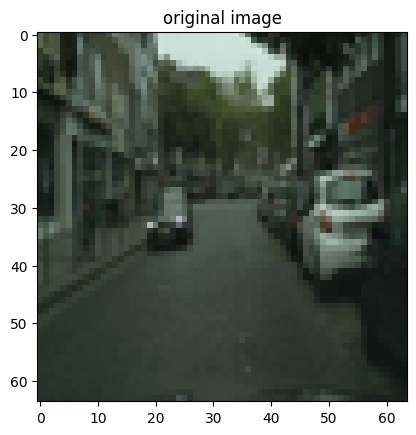

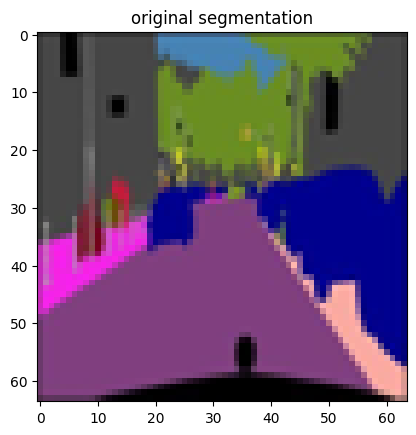

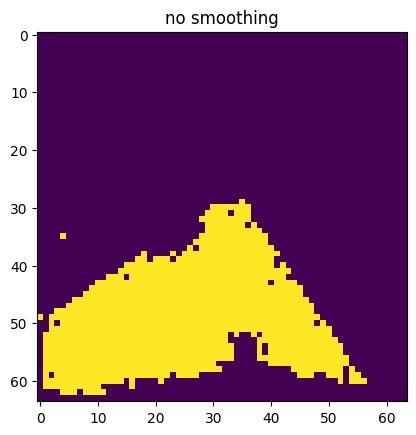

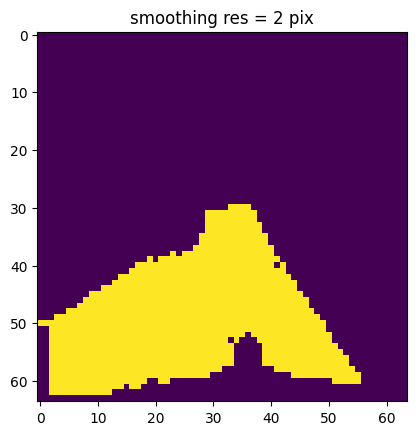

In [5]:
smooth_scale = 2
resize = True
img1, img2, mask2, mask2_smoothed = preprocess(datapath+'train/100.jpg', smoothing_scale=smooth_scale, resize = resize)

plt.figure()
plt.imshow(img1)
plt.title('original image')
plt.figure()
plt.imshow(img2)
plt.title('original segmentation')


plt.figure()
plt.imshow(mask2)
plt.title('no smoothing')
plt.figure()
plt.title(f'smoothing res = {smooth_scale} pix')
plt.imshow(mask2_smoothed)




In [6]:
def prepare_tensor_dataset(train_path, val_path, smooth_scale = 8):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
    for file in tqdm(os.listdir(train_path)):
        input, _, _, target = preprocess(f"{train_path}/{file}", smoothing_scale=smooth_scale, resize = resize)
        X_train.append(input)
        Y_train.append(target)

    for file in tqdm(os.listdir(val_path)):
        input, _, _, target = preprocess(f"{val_path}/{file}", smoothing_scale=smooth_scale, resize = resize)
        X_val.append(input)
        Y_val.append(target)

    return X_train, Y_train, X_val, Y_val

In [7]:
X_train, Y_train, X_valid, Y_valid = prepare_tensor_dataset(datapath+'train/',datapath+'val/')

100%|██████████| 500/500 [00:14<00:00, 34.16it/s] 


In [8]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_valid = np.array(X_valid)
Y_valid = np.array(Y_valid)

# U-net Model

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model


if resize:
  input_size = 64
else:
  input_size = 256

def unet(input_shape, filters_list):
    inputs = Input(input_shape)
    num_layers = len(filters_list)

    # Encoder
    conv_layers = []
    pool = inputs
    for filters in filters_list:
        conv = Conv2D(filters, 3, activation='relu', padding='same')(pool)
        conv = Conv2D(filters, 3, activation='relu', padding='same')(conv)
        conv_layers.append(conv)
        pool = MaxPooling2D(pool_size=(2, 2))(conv)

    # Middle
    conv = Conv2D(filters * (2 ** num_layers), 3, activation='relu', padding='same')(pool)
    conv = Conv2D(filters * (2 ** num_layers), 3, activation='relu', padding='same')(conv)

    # Decoder
    for i, filters in enumerate(reversed(filters_list)):
        up = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(conv)
        concat = concatenate([conv_layers[num_layers - i - 1], up], axis=3)
        conv = Conv2D(filters, 3, activation='relu', padding='same')(concat)
        conv = Conv2D(filters, 3, activation='relu', padding='same')(conv)

    # Output layer
    outputs = Conv2D(1, 1, activation='sigmoid')(conv)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model


# Create the model
model = unet(input_shape = (input_size,input_size,3), filters_list = [64, 32, 16])
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 64)           1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 64, 64, 64)           36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

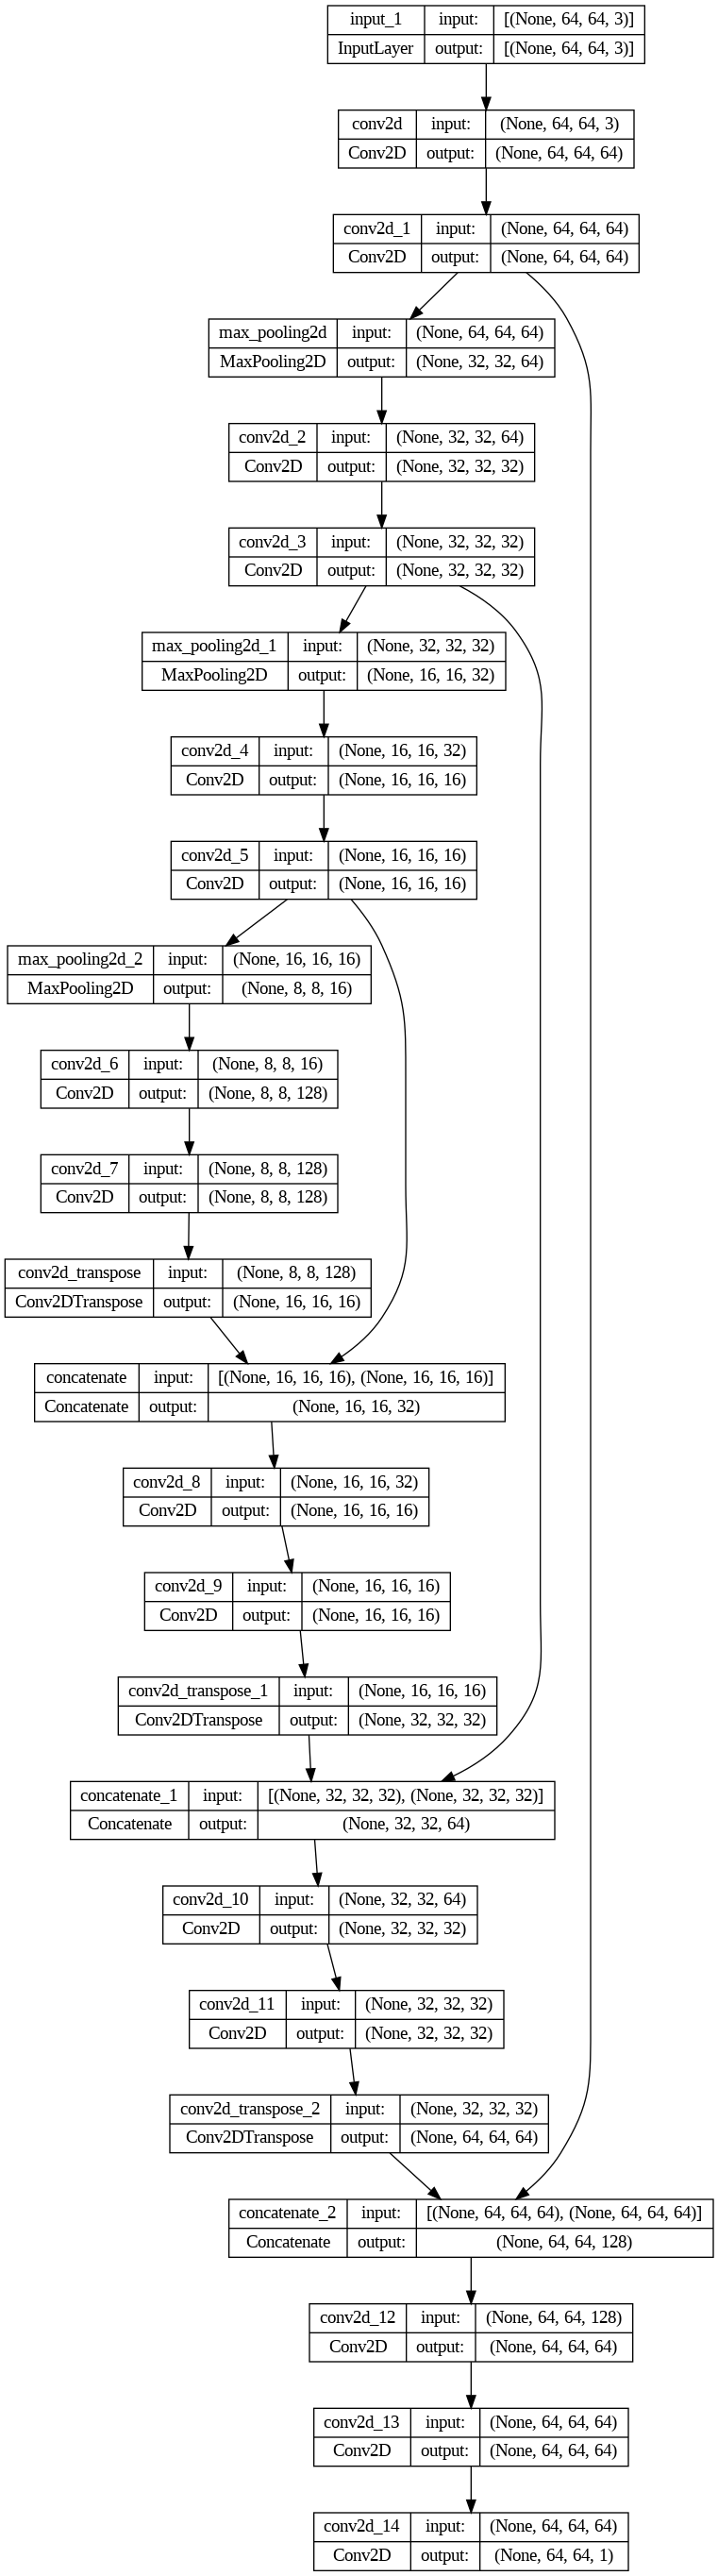

In [11]:
tf.keras.utils.plot_model(model, show_shapes = True)

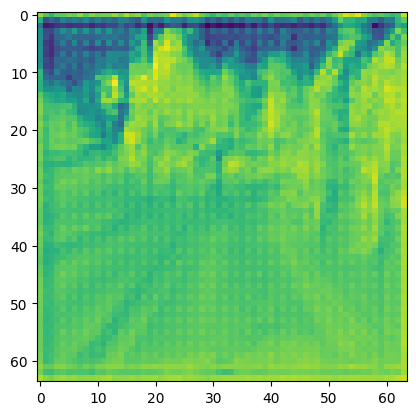

In [12]:
#process one image

pred = model(X_train[2:3])
plt.imshow(pred[0].numpy())

In [13]:
LEARNING_RATE = 1e-6 #default is 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["accuracy"])

# Training

In [14]:
BATCH_SIZE = 128
EPOCHS = 10
history = model.fit(x=X_train, y=Y_train, epochs = EPOCHS, batch_size = BATCH_SIZE)#, validation_data = (X_valid, Y_valid))

Epoch 1/10
11/11 [==============================] - 98s 9s/step - loss: 0.6858 - accuracy: 0.7868
Epoch 2/10
11/11 [==============================] - 93s 8s/step - loss: 0.6853 - accuracy: 0.7887
Epoch 3/10


KeyboardInterrupt: 

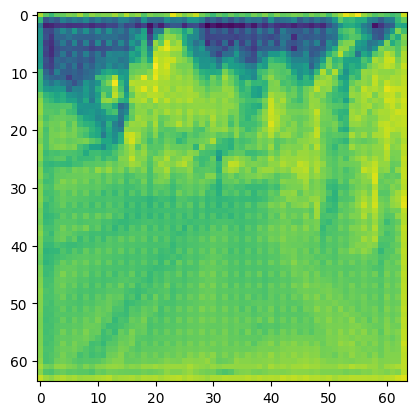

In [15]:
#process one image

pred = model(X_train[2:3])
plt.imshow(pred[0].numpy())